In [1]:
from src.utils_py.auxil import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors
import matplotlib.animation as animation
from random import randint
from scipy.ndimage import gaussian_filter, uniform_filter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Polygon
from scipy.spatial import Delaunay
from scipy.signal import convolve2d
import ast
from time import perf_counter

# Случай, когда $\theta$ = 180º

In [2]:
N_phi = 100
arr_phi = np.linspace(0, 1, N_phi, endpoint=True)

M_l = 100
arr_l = np.linspace(0.1, 7, M_l, endpoint=True)

grid = np.zeros((M_l, N_phi), dtype=int)

for i, l in enumerate(arr_l):
    for j, phi in enumerate(arr_phi):
        S = np.array([
            S_droplet_180(l, phi),
            S_doughnut_180(l, phi),
            S_worm_180(l, phi),
            S_roll_180(l, phi),
            S_perforation_180(l, phi),
            S_layer_180(l, phi)
        ])

        grid[i, j] = np.argmin(S)

plt.figure(figsize=(8, 6))
plt.title(r'$\theta$'+'={:.1f}'.format(np.rad2deg(theta)), fontsize=16)

names = np.array(['droplet', 'doughnut', 'worm', 'roll', 'perforation', 'layer'])
colors = ["#ea3930", "#ffb534", "#3499e8", "#a946ff", "#32ff92", "#a9a9a9"]
color_map = matplotlib.colors.ListedColormap(colors)
im = plt.imshow(grid[::-1, :], cmap=color_map, extent=[0, 1, 0, 7], aspect="auto")

patches = [ mpatches.Patch(color=colors[i], label=names[i]) for i in range(6) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. , fontsize=14)

plt.xlabel(r'$\phi$', fontsize=14)
plt.ylabel(r'$l$', fontsize=14)
plt.show()

NameError: name 'theta' is not defined

<Figure size 800x600 with 0 Axes>

In [3]:
phi = 0.5
l = 3

print(S_droplet_180(phi, l))
print(S_doughnut_180(phi, l))
print(S_worm_180(phi, l))
print(S_roll_180(phi, l))
print(S_perforation_180(phi, l))
print(S_layer_180(phi, l))

inf
inf
inf
inf
inf
inf


# Случай произвольного угла $\theta$

In [2]:
def draw_phase_diagramm(N_phi, M_l, theta, l_max=7):
    arr_phi = np.linspace(0, 1, N_phi, endpoint=True)

    arr_l = np.linspace(0.001, l_max, M_l, endpoint=True)

    grid = np.zeros((M_l, N_phi), dtype=int)

    for i, l in enumerate(arr_l):
        for j, phi in enumerate(arr_phi):
            S = np.array([
                S_droplet_theta(l, phi, theta),
                S_doughnut_theta(l, phi, theta),
                S_worm_theta(l, phi, theta),
                S_roll_theta(l, phi, theta),
                S_perforation_theta(l, phi, theta),
                S_layer_theta(l, phi, theta)
            ])

            grid[i, j] = np.argmin(S)

    return grid

In [3]:
def check_neighbors(i, j, grid):
    value = grid[i, j]

    # Получаем значения соседей и проверяем, находятся ли они в пределах массива
    neighbors = []
    for x in range(i-1, i+2):
        for y in range(j-1, j+2):
            if 0 <= x < grid.shape[0] and 0 <= y < grid.shape[1]:
                neighbors.append(grid[x, y])
    # for k in range(4):
    #     x = i + (2 * k + 1) % 3 - 1
    #     y = j + (2 * k + 1) // 3 - 1
    #     if 0 <= x < grid.shape[0] and 0 <= y < grid.shape[1]:
    #         neighbors.append(grid[x, y])

    # Проверяем совпадение значения с соседями
    return np.allclose(value, neighbors)

Processing 90.1


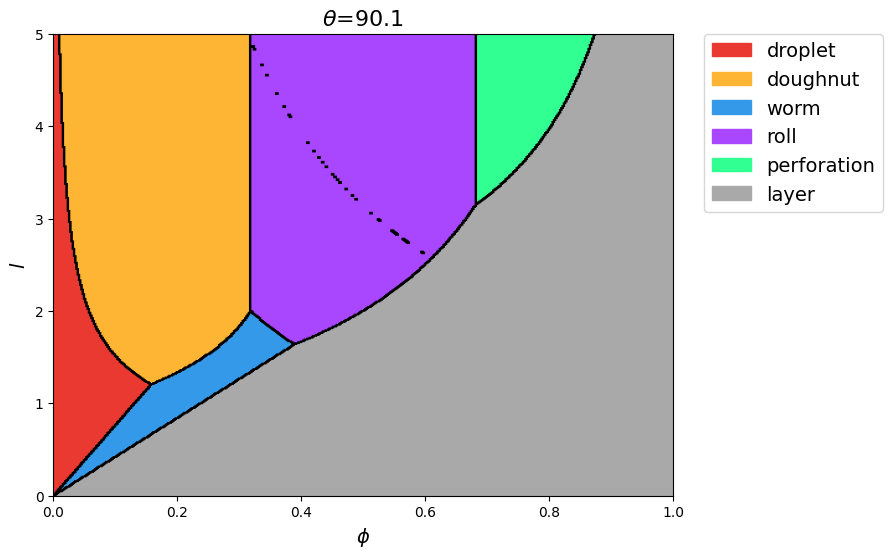

In [8]:
# for theta in range(180, 90, -10):
theta = 90.1
l = 5
print('Processing '+str(theta))
WIDTH, HEIGHT = 500, 500
grid = draw_phase_diagramm(WIDTH, HEIGHT, np.deg2rad(theta), l_max=l)

mask = np.ones_like(grid)

for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if check_neighbors(i, j, grid):
            mask[i, j] = 0

size = 1 # параметр сглаживания, можете настроить по вашему вкусу
sigma = 1
smoothed_mask = uniform_filter(mask.astype(float), size=size)
# smoothed_mask = gaussian_filter(mask.astype(float), sigma=sigma)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_title(r'$\theta$'+'={:.1f}'.format(theta), fontsize=16)

names = np.array(['droplet', 'doughnut', 'worm', 'roll', 'perforation', 'layer'])
colors = ["#ea3930", "#ffb534", "#3499e8", "#a946ff", "#32ff92", "#a9a9a9"]
color_map = matplotlib.colors.ListedColormap(colors)
ax.imshow(grid[::-1, :], cmap=color_map, extent=[0, 1, 0, l], aspect="auto")

# np.save(f'phase_diagrams/{theta}_grid', grid)

smooth_name = "smooth pallete"
smooth_colors = [(0, 0, 0, 0), (0, 0, 0, 1)]  # от прозрачности до непрозрачности
n_bins = 100  # количество оттенков в градиенте
smooth_cmap = LinearSegmentedColormap.from_list(smooth_name, smooth_colors, N=n_bins)

# ax.imshow(smoothed_mask > 0, cmap='gray', alpha=smoothed_mask[::-1, :])
ax.imshow(smoothed_mask[::-1, :], cmap=smooth_cmap, extent=[0, 1, 0, l], aspect="auto", vmin=0, vmax=1)
# np.save(f'phase_diagrams/{theta}_mask', smoothed_mask)

patches = [ mpatches.Patch(color=colors[i], label=names[i]) for i in range(6) ]
lgd = ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. , fontsize=14)

ax.set_xlabel(r'$\phi$', fontsize=14)
ax.set_ylabel(r'$l$', fontsize=14)

# fig.savefig(f'img/{theta}.png', bbox_inches='tight')
plt.show()

# Рисуем анимацию

MovieWriter imagemagick unavailable; using Pillow instead.


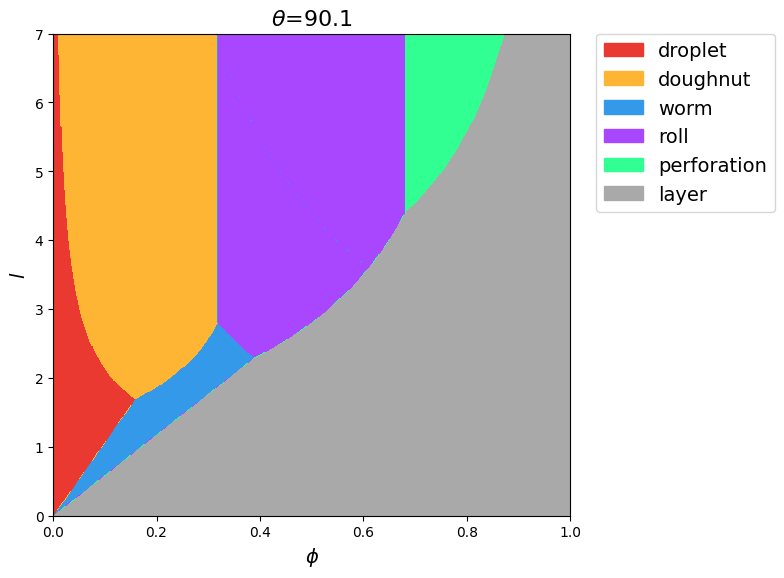

In [58]:
N = 500
M = 500
theta = np.linspace(180, 90.1, 50, endpoint=True)


# Создаем график
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

grid = draw_phase_diagramm(N, M, np.deg2rad(180), l_max=5)
names = np.array(['droplet', 'doughnut', 'worm', 'roll', 'perforation', 'layer'])
colors = ["#ea3930", "#ffb534", "#3499e8", "#a946ff", "#32ff92", "#a9a9a9"]
color_map = matplotlib.colors.ListedColormap(colors)
im = ax.imshow(grid[::-1, :], cmap=color_map, extent=[0, 1, 0, 7], aspect="auto")

patches = [ mpatches.Patch(color=colors[i], label=names[i]) for i in range(6) ]
lgd = ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. , fontsize=14)

ax.set_xlabel(r'$\phi$', fontsize=14)
ax.set_ylabel(r'$l$', fontsize=14)

def update_grid(frame):
    # Здесь может быть ваш код для обновления массива grid
    # Например, изменение некоторых элементов массива
    ax.set_title(r'$\theta$'+'={:.1f}'.format(theta[frame]), fontsize=16)
    im.set_array(draw_phase_diagramm(N, M, np.deg2rad(theta[frame]), l_max=5)[::-1, :])
    return im,

# Функция для инициализации
def init():
    im.set_array(draw_phase_diagramm(N, M, np.deg2rad(180), l_max=5))
    return im,

# Создаем анимацию
ani = animation.FuncAnimation(fig, update_grid, frames=len(theta), init_func=init, blit=True, interval=500)

plt.tight_layout(rect=(0, 0, 1, 0.95))
# Сохраняем анимацию в видеофайл (формат GIF)
ani.save('img/animation.gif', writer='imagemagick', fps=len(theta)/10)

# plt.show()

---

## Объединение графиков на одном

In [72]:
plt.rcParams['font.family'] = 'Helvetica'

In [89]:
grid = np.load('phase_diagrams/180_grid.npy')

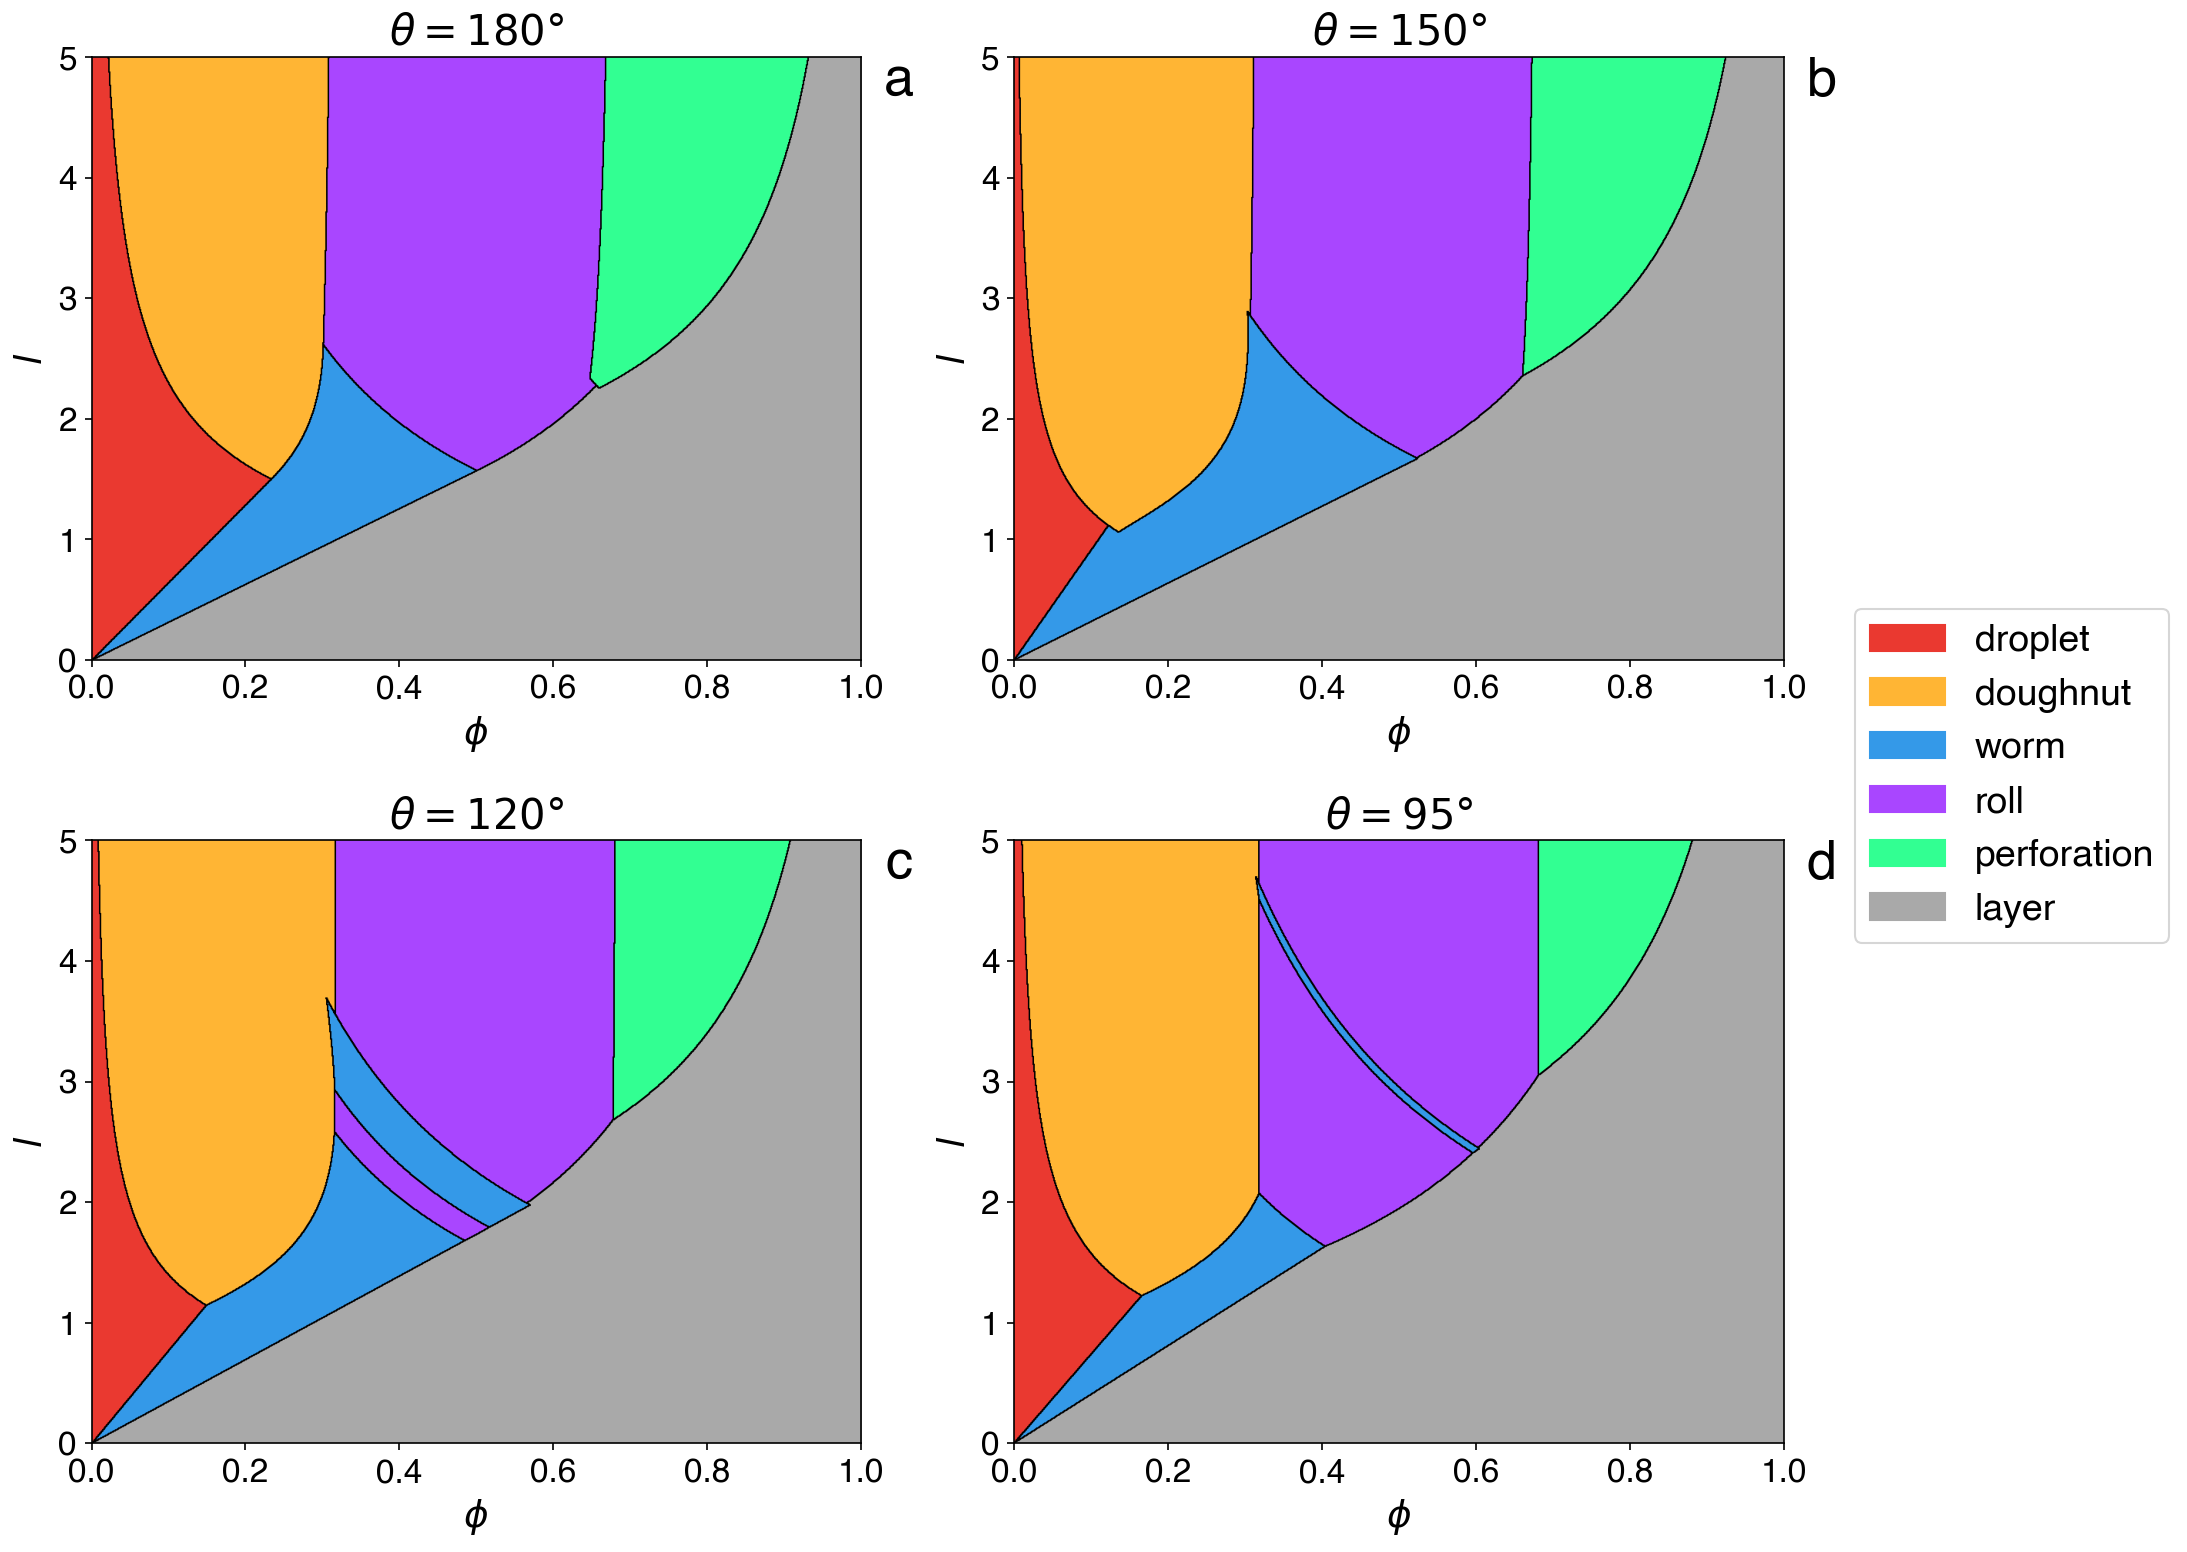

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Define angles and corresponding filenames
angles = [180, 150, 120, 95]
grid_filenames = [f'phase_diagrams/{angle}_grid.npy' for angle in angles]
mask_filenames = [f'phase_diagrams/{angle}_mask.npy' for angle in angles]

# Define phase diagram names and colors
names = np.array(['droplet', 'doughnut', 'worm', 'roll', 'perforation', 'layer'])
colors = ["#ea3930", "#ffb534", "#3499e8", "#a946ff", "#32ff92", "#a9a9a9"]

# Create a custom color map
color_map = ListedColormap(colors)

# Create a smooth color map for the mask
smooth_name = "smooth_palette"
smooth_colors = [(0, 0, 0, 0), (0, 0, 0, 1)]  # from transparent to black
n_bins = 100  # number of shades in the gradient
smooth_cmap = LinearSegmentedColormap.from_list(smooth_name, smooth_colors, N=n_bins)

# Create a figure and axes for a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(16, 12), dpi=150)

# Plot each phase diagram
i = 0
for ax, angle, grid_filename, mask_filename in zip(axs.ravel(), angles, grid_filenames, mask_filenames):
    # Load the grid and mask data
    grid = np.load(grid_filename)
    smooth_mask = np.load(mask_filename)

    # Plot the phase diagram
    ax.imshow(grid[::-1, :], cmap=color_map, extent=[0, 1, 0, 5], aspect='auto')
    ax.imshow(smooth_mask[::-1, :], cmap=smooth_cmap, extent=[0, 1, 0, 5], aspect='auto', vmin=0, vmax=1)
    ax.set_title(f'$\\theta={angle}\degree$', fontsize=20)
    ax.set_xlabel(r'$\phi$', fontsize=18)
    ax.set_ylabel(r'$l$', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.text(1.05, 0.96, chr(97 + i), transform=ax.transAxes,
                           fontsize=26, color='black', ha='center', va='center')
    i += 1

# Create a single legend for all subplots
patches = [mpatches.Patch(color=colors[i], label=names[i]) for i in range(len(names))]
fig.legend(handles=patches, loc='center right', fontsize=18)
# fig.legend(handles=patches, loc=(9), fontsize=18)

# Adjust layout to make space for the legend
plt.subplots_adjust(right=0.83, hspace=0.3)

# Add labels (a, b, c, d) in the bottom right corner of each image
label_positions = [(0.47, 0.88),  # Bottom-right corner of the top-left image
                   (0.92, 0.9),  # Bottom-right corner of the top-right image
                   (0.46, 0.1),  # Bottom-right corner of the bottom-left image
                   (0.92, 0.1)]  # Bottom-right corner of the bottom-right image

# labels = ['a', 'b', 'c', 'd']

# # Add each label to the figure
# for label, (x, y) in zip(labels, label_positions):
#     fig.text(x, y, label, fontsize=24, ha='center', va='center', transform=fig.transFigure)

# Save the figure or show
plt.show()


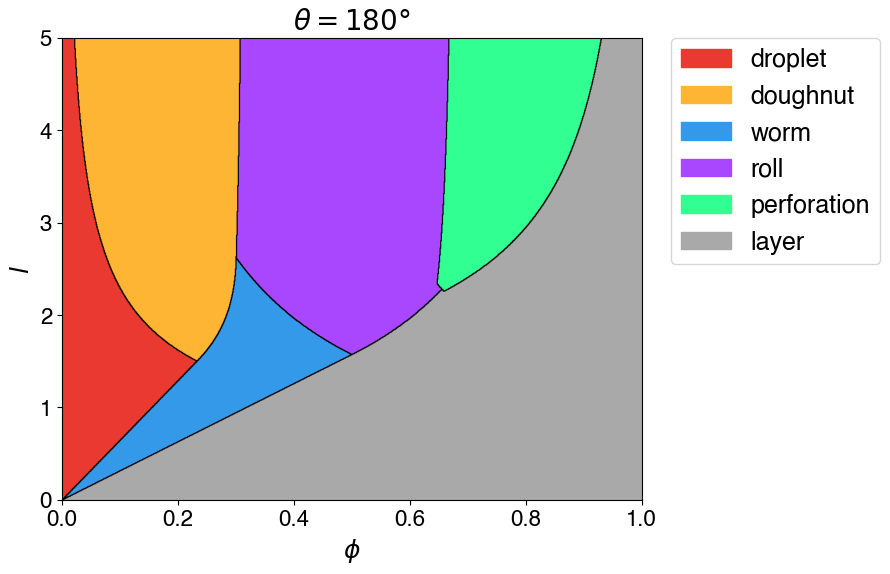

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Define angles and corresponding filenames
angles = [180]
grid_filenames = [f'phase_diagrams/{angle}_grid.npy' for angle in angles]
mask_filenames = [f'phase_diagrams/{angle}_mask.npy' for angle in angles]

# Define phase diagram names and colors
names = np.array(['droplet', 'doughnut', 'worm', 'roll', 'perforation', 'layer'])
colors = ["#ea3930", "#ffb534", "#3499e8", "#a946ff", "#32ff92", "#a9a9a9"]

# Create a custom color map
color_map = ListedColormap(colors)

# Create a smooth color map for the mask
smooth_name = "smooth_palette"
smooth_colors = [(0, 0, 0, 0), (0, 0, 0, 1)]  # from transparent to black
n_bins = 100  # number of shades in the gradient
smooth_cmap = LinearSegmentedColormap.from_list(smooth_name, smooth_colors, N=n_bins)

# Create a figure and axes for a 2x2 grid
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot each phase diagram
for angle, grid_filename, mask_filename in zip(angles, grid_filenames, mask_filenames):
    # Load the grid and mask data
    grid = np.load(grid_filename)
    smooth_mask = np.load(mask_filename)

    # Plot the phase diagram
    ax.imshow(grid[::-1, :], cmap=color_map, extent=[0, 1, 0, 5], aspect='auto')
    ax.imshow(smooth_mask[::-1, :], cmap=smooth_cmap, extent=[0, 1, 0, 5], aspect='auto', vmin=0, vmax=1)
    ax.set_title(f'$\\theta={angle}\degree$', fontsize=20)
    ax.set_xlabel(r'$\phi$', fontsize=18)
    ax.set_ylabel(r'$l$', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)

# # Create a single legend for all subplots
patches = [mpatches.Patch(color=colors[i], label=names[i]) for i in range(len(names))]
lgd = ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. , fontsize=18)


# Adjust layout to make space for the legend
plt.subplots_adjust(right=0.85, hspace=0.3)

# Save the figure or show
plt.show()


---

## Фазовая диаграмма в случае ненулевого слоя смачивания

In [8]:
def draw_phase_diagramm_delta(N_phi, M_l, delta, l_max=7):
    arr_phi = np.linspace(0, 1 - 2 * delta, N_phi, endpoint=True)

    arr_l = np.linspace(0.001, l_max, M_l, endpoint=True)

    grid = np.zeros((M_l, N_phi), dtype=int)

    for i, l in enumerate(arr_l):
        for j, phi in enumerate(arr_phi):
            S = np.array([
                S_droplet_delta(l, phi, delta),
                S_doughnut_delta(l, phi, delta),
                S_worm_delta(l, phi, delta),
                S_roll_delta(l, phi, delta),
                S_perforation_delta(l, phi, delta),
                S_layer_delta(l, phi, delta)
            ])

            grid[i, j] = np.argmin(S)

    return grid

In [3]:
def check_neighbors(i, j, grid):
    value = grid[i, j]

    # Получаем значения соседей и проверяем, находятся ли они в пределах массива
    neighbors = []
    for x in range(i-1, i+2):
        for y in range(j-1, j+2):
            if 0 <= x < grid.shape[0] and 0 <= y < grid.shape[1]:
                neighbors.append(grid[x, y])
    # for k in range(4):
    #     x = i + (2 * k + 1) % 3 - 1
    #     y = j + (2 * k + 1) // 3 - 1
    #     if 0 <= x < grid.shape[0] and 0 <= y < grid.shape[1]:
    #         neighbors.append(grid[x, y])

    # Проверяем совпадение значения с соседями
    return np.allclose(value, neighbors)

Processing: delta 0.2


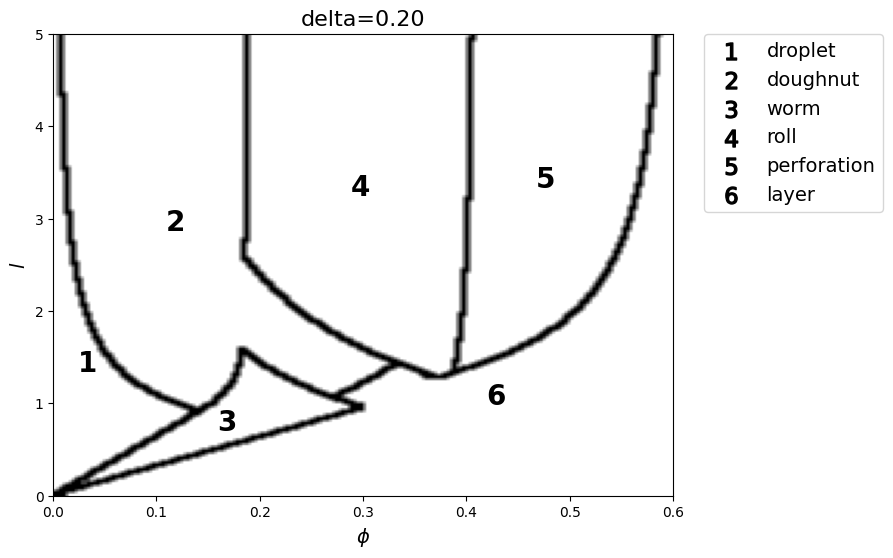

In [51]:
# for theta in range(180, 90, -10):
delta = 0.2
l = 5
print('Processing: delta '+str(delta))
WIDTH, HEIGHT = 200, 200
grid = draw_phase_diagramm_delta(WIDTH, HEIGHT, delta, l_max=l)

index_grid = np.zeros((*grid.shape, 3), dtype=int)

for i, a in np.ndenumerate(grid):
    index_grid[i[0], i[1], :] = [*i, a]

mask = np.ones_like(grid)

for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if check_neighbors(i, j, grid):
            mask[i, j] = 0

size = 2 # параметр сглаживания, можете настроить по вашему вкусу
sigma = 1
smoothed_mask = uniform_filter(mask.astype(float), size=size)
# smoothed_mask = gaussian_filter(mask.astype(float), sigma=sigma)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_title('delta'+'={:.2f}'.format(delta), fontsize=16)

names = np.array(['droplet', 'doughnut', 'worm', 'roll', 'perforation', 'layer'])
colors = ["#ea3930", "#ffb534", "#3499e8", "#a946ff", "#32ff92", "#a9a9a9"]
color_map = matplotlib.colors.ListedColormap(colors)

# ax.imshow(grid[::-1, :], cmap=color_map, extent=[0, 1 - 2 * delta, 0, l], aspect="auto")
# ax.imshow(index_grid[::-1, :, 2], cmap=color_map, extent=[0, 1 - 2 * delta, 0, l], aspect="auto")
# ax.imshow(index_grid[::-1, :, 2], cmap=color_map, extent=[0, 1 - 2 * delta, 0, l], aspect="auto")
# index_grid[index_grid[:, :, 2] == 1, :].mean(axis=0).astype(int)
np.save(f'phase_diagrams/delta_{delta}_grid', grid)

label_pos = []
for i in range(len(names)):
    pos = index_grid[index_grid[:, :, 2] == i, :].mean(axis=0)[:2]
    pos /= np.array([WIDTH, HEIGHT])
    pos = pos[::-1]
    # label_pos.append(list(index_grid[index_grid[:, :, 2] == i, :].mean(axis=0)[:2].astype(int)))
    ax.text(*pos, str(i+1), fontsize=20, ha='center', va='center', transform=ax.transAxes, fontweight='bold')

smooth_name = "smooth pallete"
smooth_colors = [(0, 0, 0, 0), (0, 0, 0, 1)]  # от прозрачности до непрозрачности
n_bins = 100  # количество оттенков в градиенте
smooth_cmap = LinearSegmentedColormap.from_list(smooth_name, smooth_colors, N=n_bins)

# ax.imshow(smoothed_mask > 0, cmap='gray', alpha=smoothed_mask[::-1, :])
ax.imshow(smoothed_mask[::-1, :], cmap=smooth_cmap, extent=[0, 1 - 2 * delta, 0, l], aspect="auto", vmin=0, vmax=1)
np.save(f'phase_diagrams/delta_{delta}_mask', smoothed_mask)

# patches = [ mpatches.Patch(color='white', label=names[i]) for i in range(6) ]
unicodes = [u'$\u0031$', u'$\u0032$', u'$\u0033$', u'$\u0034$', u'$\u0035$', u'$\u0036$']
patches = [ ax.scatter([], [], c='black', marker=unicodes[i], s=150, label=names[i])  for i in range(6) ]
lgd = ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. , fontsize=14)

ax.set_xlabel(r'$\phi$', fontsize=14)
ax.set_ylabel(r'$l$', fontsize=14)

fig.savefig(f'img/delta_{delta}.png', bbox_inches='tight')
plt.show()

---

# Закрашивание областей

In [51]:
plt.rcParams['font.family'] = 'Helvetica'

In [32]:
def draw_phase_diagramm_delta(N_phi, M_l, delta, l_max=7):
    arr_phi = np.linspace(0, 1 - 2 * delta, N_phi, endpoint=True)

    arr_l = np.linspace(0.001, l_max, M_l, endpoint=True)

    grid = np.zeros((M_l, N_phi), dtype=int)

    for i, l in enumerate(arr_l):
        for j, phi in enumerate(arr_phi):
            S = np.array([
                S_droplet_delta(l, phi, delta),
                S_doughnut_delta(l, phi, delta),
                S_worm_delta(l, phi, delta),
                S_roll_delta(l, phi, delta),
                S_perforation_delta(l, phi, delta),
                S_layer_delta(l, phi, delta)
            ])

            grid[i, j] = np.argmin(S) + 1

    return grid

In [3]:
def check_neighbors(i, j, grid):
    value = grid[i, j]

    # Получаем значения соседей и проверяем, находятся ли они в пределах массива
    neighbors = []
    for x in range(i-1, i+2):
        for y in range(j-1, j+2):
            if 0 <= x < grid.shape[0] and 0 <= y < grid.shape[1]:
                neighbors.append(grid[x, y])
    # for k in range(4):
    #     x = i + (2 * k + 1) % 3 - 1
    #     y = j + (2 * k + 1) // 3 - 1
    #     if 0 <= x < grid.shape[0] and 0 <= y < grid.shape[1]:
    #         neighbors.append(grid[x, y])

    # Проверяем совпадение значения с соседями
    return np.allclose(value, neighbors)

In [4]:
filter = np.array([
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0]
], dtype=int)

def get_border(grid, type):
    region = grid.copy()
    region[region!=type] = 0
    region[region==type] = 1
    region_conv = convolve2d(filter, region)[1:-1, 1:-1]
    region[region_conv > 3] = 0

    return region

In [5]:
def get_region(grid, type):
    region = grid.copy()
    region[region!=type] = 0
    region[region==type] = 1

    return region

In [6]:
"""
https://stackoverflow.com/questions/50549128/boundary-enclosing-a-given-set-of-points/50714300#50714300
"""
def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.simplices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

In [7]:
def find_edges_with(i, edge_set):
    i_first = [j for (x,j) in edge_set if x==i]
    i_second = [j for (j,x) in edge_set if x==i]
    return i_first,i_second

In [8]:
def stitch_boundaries(edges):
    edge_set = edges.copy()
    boundary_lst = []
    while len(edge_set) > 0:
        boundary = []
        edge0 = edge_set.pop()
        boundary.append(edge0)
        last_edge = edge0
        while len(edge_set) > 0:
            i,j = last_edge
            j_first, j_second = find_edges_with(j, edge_set)
            if j_first:
                edge_set.remove((j, j_first[0]))
                edge_with_j = (j, j_first[0])
                boundary.append(edge_with_j)
                last_edge = edge_with_j
            elif j_second:
                edge_set.remove((j_second[0], j))
                edge_with_j = (j, j_second[0])  # flip edge rep
                boundary.append(edge_with_j)
                last_edge = edge_with_j

            if edge0[0] == last_edge[1]:
                break

        boundary_lst.append(boundary)
    return boundary_lst

In [9]:
def edge2xy(edges, xy):
    xy_ = list()
    xy_.append(xy[edges[0][0]].tolist())
    for e in edges:
        xy_.append(xy[e[1]].tolist())

    return np.array(xy_, dtype=int)

Processing: delta 0.15
Creating grid: 10.484092457976658
Creating mask: 23.372550958010834
Creating edges: 1.4004673750023358
Creating bound: 0.18975616700481623
Creating edges: 5.027681875042617
Creating bound: 0.21746799995889887
Creating edges: 0.903812124975957
Creating bound: 0.05071554100140929
Creating edges: 5.211834874993656
Creating bound: 0.1486868750071153
Creating edges: 3.521485416975338
Creating bound: 0.1238099160254933
Creating edges: 6.490797249949537
Creating bound: 0.5256358329788782


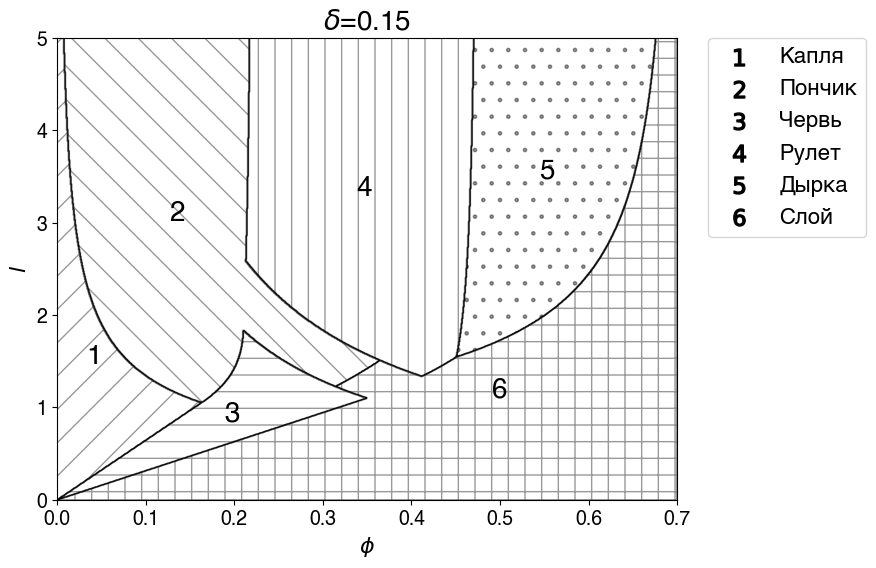

In [131]:
# for theta in range(180, 90, -10):
delta = 0.15
l = 5

save_flag = True
read_flag = False

title_size = 20
label_size = 16
region_label_size = 20
legend_size = 16
tick_size = 14

print('Processing: delta '+str(delta))
WIDTH, HEIGHT = 1000, 1000
if read_flag:
    grid = np.load(f'phase_diagrams/delta_{delta}_grid.npy')
else:
    start = perf_counter()
    grid = draw_phase_diagramm_delta(WIDTH, HEIGHT, delta, l_max=l)
    print('Creating grid:', perf_counter() - start)

index_grid = np.zeros((*grid.shape, 3), dtype=int)

for i, a in np.ndenumerate(grid):
    index_grid[i[0], i[1], :] = [*i, a]

if read_flag:
    mask = np.load(f'phase_diagrams/delta_{delta}_mask.npy')
else:
    mask = np.ones_like(grid)
    start = perf_counter()
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if check_neighbors(i, j, grid):
                mask[i, j] = 0
    print('Creating mask:', perf_counter() - start)

if save_flag: np.save(f'phase_diagrams/delta_{delta}_mask', mask)


size = 2 # параметр сглаживания, можете настроить по вашему вкусу
sigma = 1
smoothed_mask = uniform_filter(mask.astype(float), size=size)
# smoothed_mask = gaussian_filter(mask.astype(float), sigma=sigma)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_title(r'$\delta$'+'={:.2f}'.format(delta), fontsize=title_size)

# names = np.array(['droplet', 'doughnut', 'worm', 'roll', 'perforation', 'layer'])
names = np.array(['Капля', 'Пончик', 'Червь', 'Рулет', 'Дырка', 'Слой'])
colors = ["#ea3930", "#ffb534", "#3499e8", "#a946ff", "#32ff92", "#a9a9a9"]
color_map = matplotlib.colors.ListedColormap(colors)

# ax.imshow(grid[::-1, :], cmap=color_map, extent=[0, 1 - 2 * delta, 0, l], aspect="auto")
# ax.imshow(index_grid[::-1, :, 2], cmap=color_map, extent=[0, 1 - 2 * delta, 0, l], aspect="auto")
# ax.imshow(index_grid[::-1, :, 2], cmap=color_map, extent=[0, 1 - 2 * delta, 0, l], aspect="auto")
# index_grid[index_grid[:, :, 2] == 1, :].mean(axis=0).astype(int)
if save_flag: np.save(f'phase_diagrams/delta_{delta}_grid', grid)

# Отрисовка штриховки
hatches = ['/', '\\', '-', '|', '.', '+']
# hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
for type_id in range(1, len(names)+1):
    region = get_region(grid, type_id)
    xy = np.argwhere(region)

    if read_flag:
        with open(f'phase_diagrams/delta_{delta}_edges.txt', 'r') as f:
            edges = ast.literal_eval(f.read())
    else:
        start = perf_counter()
        edges = alpha_shape(xy, 1)
        print('Creating edges:', perf_counter() - start)

    if save_flag:
        with open(f'phase_diagrams/delta_{delta}_edges.txt', 'w') as f:
            f.write(str(edges))


    if read_flag:
        with open(f'phase_diagrams/delta_{delta}_bound.txt', 'r') as f:
            bound = ast.literal_eval(f.read())
    else:
        start = perf_counter()
        bound = stitch_boundaries(edges)
        print('Creating bound:', perf_counter() - start)

    if save_flag:
        with open(f'phase_diagrams/delta_{delta}_bound.txt', 'w') as f:
            f.write(str(bound))

    for ed in bound:
        xy_ = edge2xy(ed, xy)

        p = Polygon(xy_[:, ::-1] *  np.array([1 - 2 * delta, l]) / np.array([WIDTH, HEIGHT]),
                    hatch=hatches[type_id-1],
                    fill=False,
                    alpha=0.4)
        ax.add_patch(p)

label_pos = []
for i in range(1, len(names)+1):
    pos = index_grid[index_grid[:, :, 2] == i, :].mean(axis=0)[:2]
    pos /= np.array([WIDTH, HEIGHT])
    pos = pos[::-1]
    # label_pos.append(list(index_grid[index_grid[:, :, 2] == i, :].mean(axis=0)[:2].astype(int)))
    ax.text(*pos, str(i), fontsize=region_label_size, ha='center', va='center', transform=ax.transAxes, fontweight='bold')


smooth_name = "smooth pallete"
smooth_colors = [(0, 0, 0, 0), (0, 0, 0, 1)]  # от прозрачности до непрозрачности
n_bins = 100  # количество оттенков в градиенте
smooth_cmap = LinearSegmentedColormap.from_list(smooth_name, smooth_colors, N=n_bins)

# ax.imshow(smoothed_mask > 0, cmap='gray', alpha=smoothed_mask[::-1, :])
ax.imshow(smoothed_mask, cmap=smooth_cmap, extent=[0, 1 - 2 * delta, 0, l], aspect="auto", vmin=0, vmax=1, origin='lower')

patches = [ mpatches.Patch(color='white', label=names[i]) for i in range(6) ]
unicodes = [u'$\u0031$', u'$\u0032$', u'$\u0033$', u'$\u0034$', u'$\u0035$', u'$\u0036$']
patches = [ ax.scatter([], [], c='black', marker=unicodes[i], s=150, label=names[i])  for i in range(6) ]
lgd = ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. , fontsize=legend_size)

ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_size)
ax.set_xlabel(r'$\phi$', fontsize=label_size)
ax.set_ylabel(r'$l$', fontsize=label_size)

fig.savefig(f'img/delta_{delta}.png', bbox_inches='tight')
plt.show()

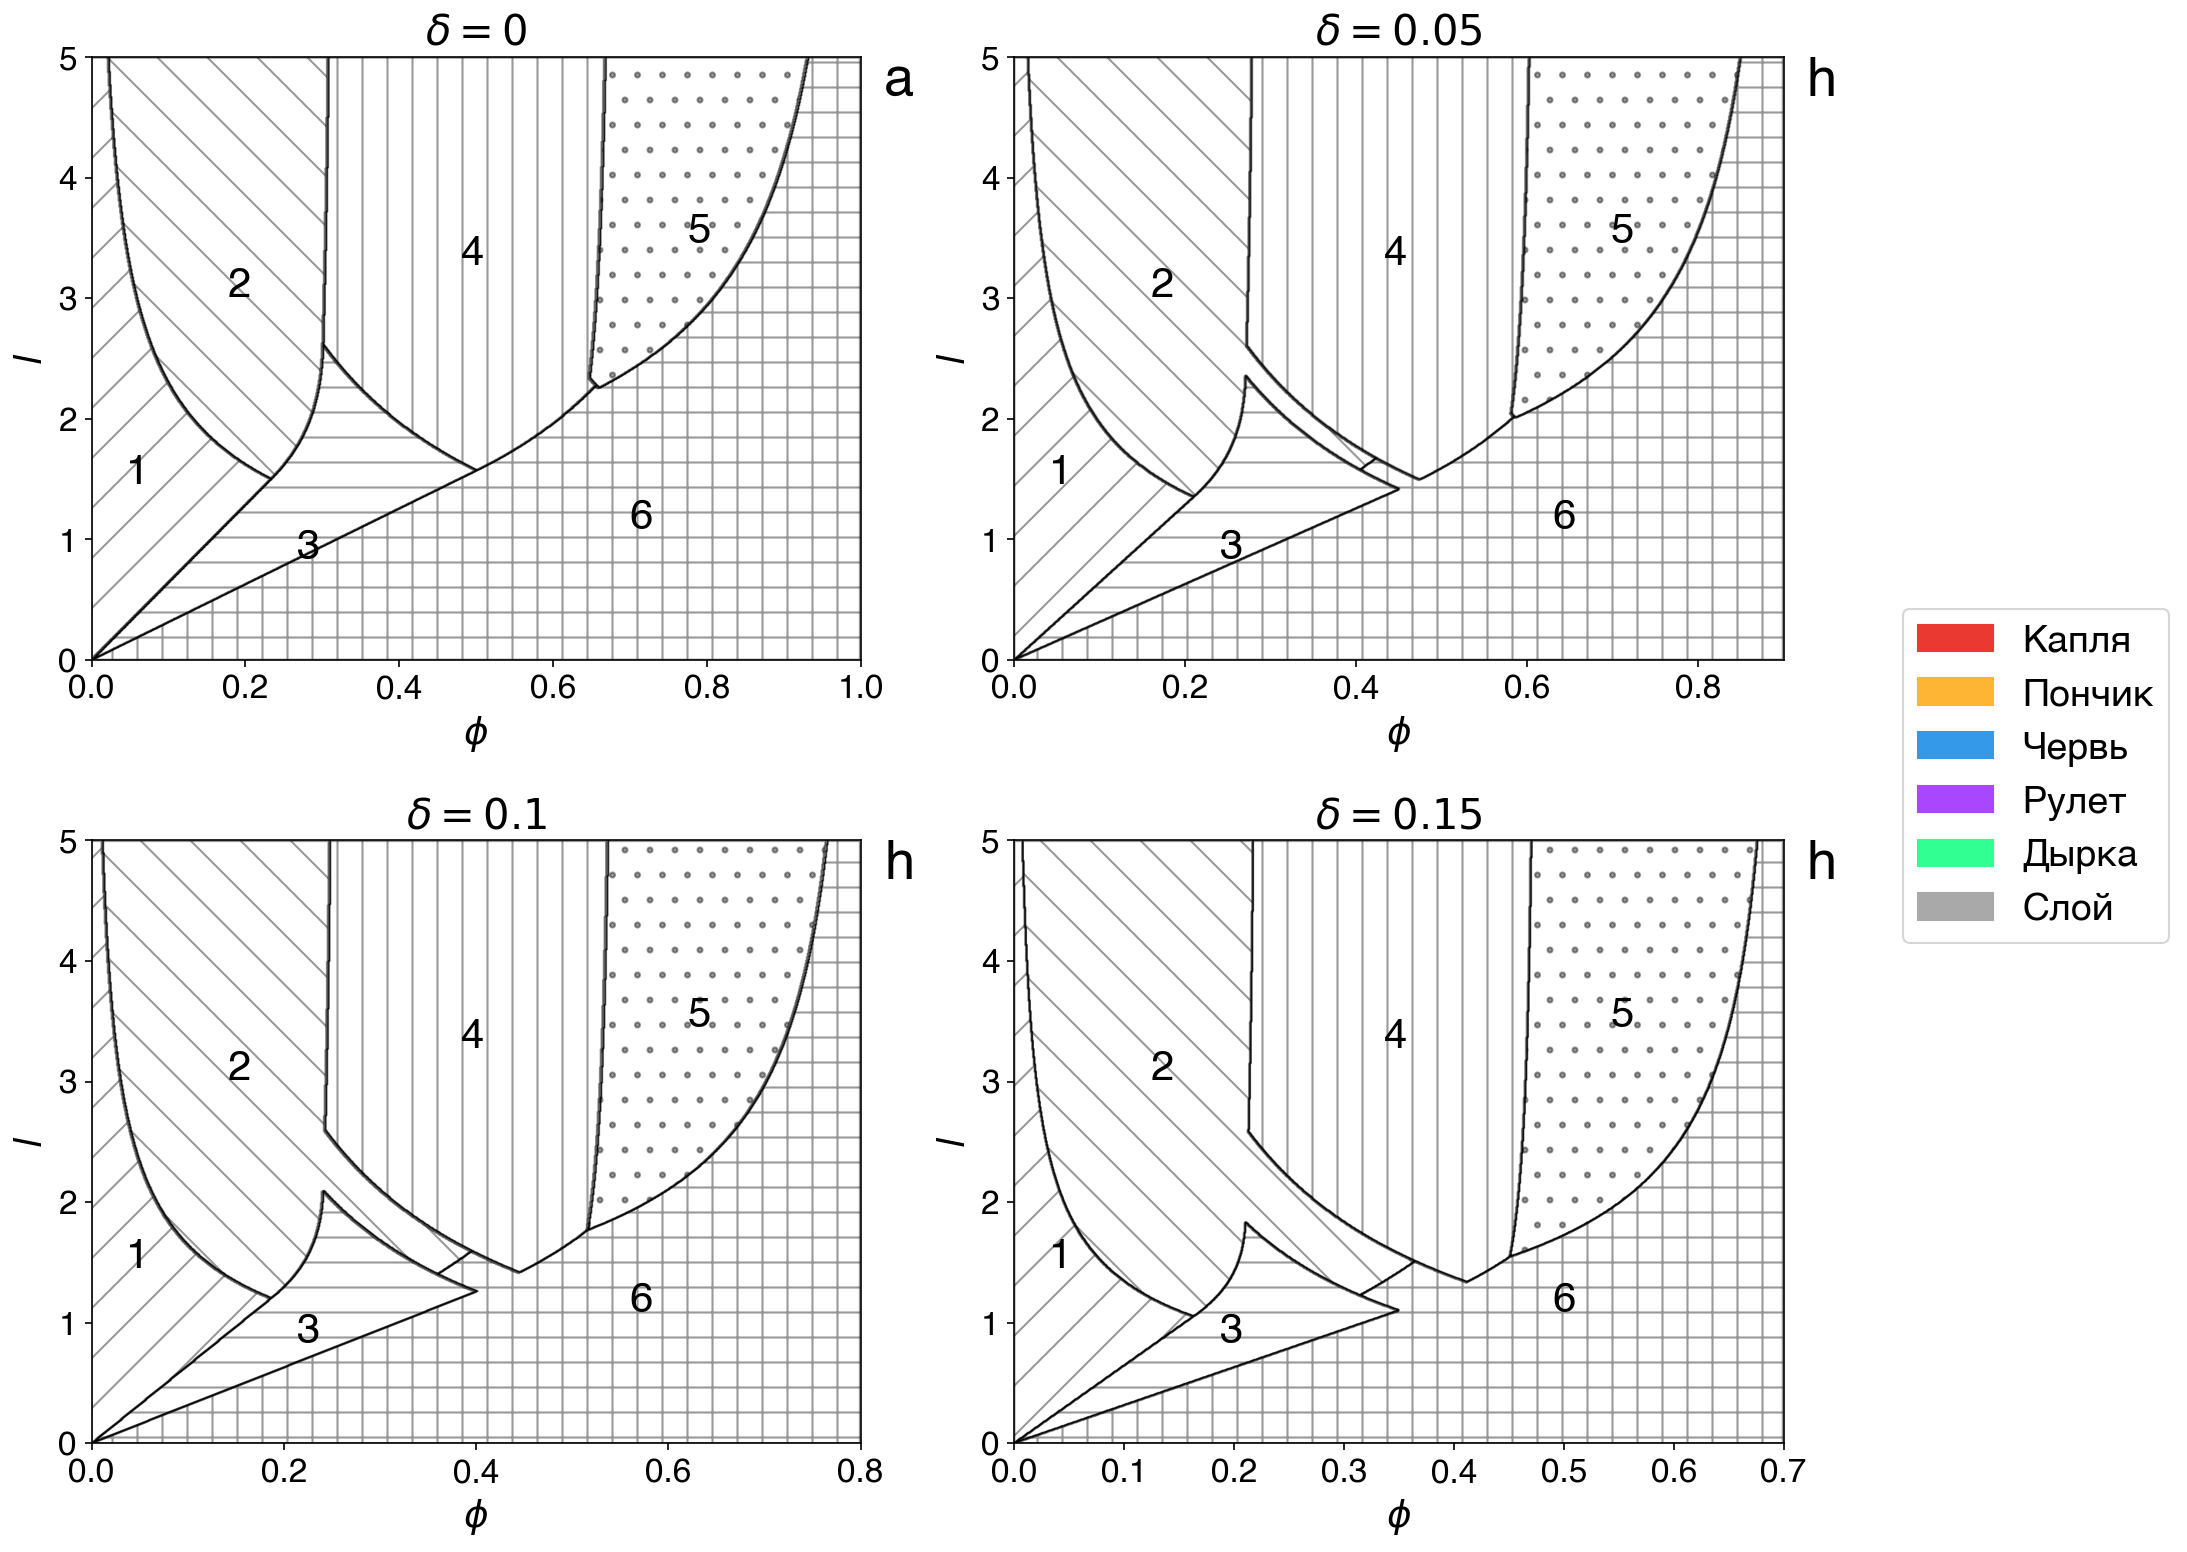

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import ast

# Define angles and corresponding filenames
deltas = [0, 0.05, 0.1, 0.15]
grid_filenames = [f'phase_diagrams/delta_{d}_grid.npy' for d in deltas]
mask_filenames = [f'phase_diagrams/delta_{d}_mask.npy' for d in deltas]

# Define phase diagram names and colors
names = np.array(['Капля', 'Пончик', 'Червь', 'Рулет', 'Дырка', 'Слой'])
hatches = ['/', '\\', '-', '|', '.', '+']

# Create a custom color map
color_map = ListedColormap(colors)

# Create a smooth color map for the mask
smooth_name = "smooth_palette"
smooth_colors = [(0, 0, 0, 0), (0, 0, 0, 1)]  # from transparent to black
n_bins = 100  # number of shades in the gradient
smooth_cmap = LinearSegmentedColormap.from_list(smooth_name, smooth_colors, N=n_bins)

# Create a figure and axes for a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(16, 12), dpi=150)

# Plot each phase diagram
i = 0
for ax, delta, grid_filename, mask_filename in zip(axs.ravel(), deltas, grid_filenames, mask_filenames):
    # Load the grid and mask data
    grid = np.load(grid_filename)
    WIDTH, HEIGHT = grid.shape

    mask = np.load(mask_filename)

    size = 2 # параметр сглаживания, можете настроить по вашему вкусу
    smooth_mask = uniform_filter(mask.astype(float), size=size)
    # smooth_mask = np.load(mask_filename)

    # Plot the phase diagram
    # ax.imshow(grid[::-1, :], cmap=color_map, extent=[0, 1, 0, 5], aspect='auto')
    # ax.imshow(smooth_mask[::-1, :], cmap=smooth_cmap, extent=[0, 1 - 2 * delta, 0, l], aspect='auto', vmin=0, vmax=1)
    ax.imshow(smooth_mask, cmap=smooth_cmap, extent=[0, 1 - 2 * delta, 0, l], aspect="auto", vmin=0, vmax=1, origin='lower')
    ax.set_title(f'$\delta={delta}$', fontsize=20)
    ax.set_xlabel(r'$\phi$', fontsize=18)
    ax.set_ylabel(r'$l$', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.text(1.05, 0.96, chr(97 + i), transform=ax.transAxes,
                           fontsize=26, color='black', ha='center', va='center')

    # Defining region
    for type_id in range(1, len(names)+1):
        region = get_region(grid, type_id)
        xy = np.argwhere(region)
        edges = alpha_shape(xy, 1)
        # with open(f'phase_diagrams/delta_{delta}_edges.txt', 'r') as f:
        #     edges = ast.literal_eval(f.read())

        bound = stitch_boundaries(edges)
        # with open(f'phase_diagrams/delta_{delta}_bound.txt', 'r') as f:
        #     bound = ast.literal_eval(f.read())

        for ed in bound:
            xy_ = edge2xy(ed, xy)

            p = Polygon(xy_[:, ::-1] *  np.array([1 - 2 * delta, l]) / np.array([WIDTH, HEIGHT]),
                        hatch=hatches[type_id-1],
                        fill=False,
                        alpha=0.4)
            ax.add_patch(p)

    # Drawing labels of regions
    label_pos = []
    for i in range(1, len(names)+1):
        pos = index_grid[index_grid[:, :, 2] == i, :].mean(axis=0)[:2]
        pos /= np.array([WIDTH, HEIGHT])
        pos = pos[::-1]
        # label_pos.append(list(index_grid[index_grid[:, :, 2] == i, :].mean(axis=0)[:2].astype(int)))
        ax.text(*pos, str(i), fontsize=region_label_size, ha='center', va='center', transform=ax.transAxes, fontweight='bold')


    i += 1

# Create a single legend for all subplots
patches = [mpatches.Patch(color=colors[i], label=names[i]) for i in range(len(names))]
fig.legend(handles=patches, loc='center right', fontsize=18)
# fig.legend(handles=patches, loc=(9), fontsize=18)

# Adjust layout to make space for the legend
plt.subplots_adjust(right=0.83, hspace=0.3)

# Add labels (a, b, c, d) in the bottom right corner of each image
label_positions = [(0.47, 0.88),  # Bottom-right corner of the top-left image
                   (0.92, 0.9),  # Bottom-right corner of the top-right image
                   (0.46, 0.1),  # Bottom-right corner of the bottom-left image
                   (0.92, 0.1)]  # Bottom-right corner of the bottom-right image

# labels = ['1', '2', '3', '4']

# # Add each label to the figure
# for label, (x, y) in zip(labels, label_positions):
#     fig.text(x, y, label, fontsize=24, ha='center', va='center', transform=fig.transFigure)

# Save the figure or show
plt.show()


In [107]:
str(edges)

'{(322464, 322581), (345110, 345171), (454, 453), (202928, 203458), (273896, 274193), (770, 769), (837, 836), (114292, 113519), (346130, 346071), (317, 316), (384, 383), (149311, 149996), (345774, 345714), (196975, 197524), (232506, 232507), (347231, 347288), (788, 787), (204514, 205039), (296152, 296356), (336260, 336341), (179651, 180253), (347331, 347332), (339343, 339269), (57712, 58603), (236950, 236523), (110, 109), (76911, 76057), (198, 197), (718, 717), (311289, 311137), (221480, 221479), (279328, 279601), (785, 784), (190235, 190806), (4977, 3985), (321637, 321517), (281480, 281215), (222572, 223089), (318154, 318283), (328725, 328625), (249536, 249147), (320302, 320179), (324404, 324292), (61, 60), (128, 127), (195, 194), (291671, 291448), (294487, 294275), (308321, 308160), (228622, 229118), (305672, 305502), (532, 531), (221007, 220482), (312189, 312040), (346425, 346483), (270840, 270841), (58, 57), (332957, 332868), (342760, 342826), (462, 461), (529, 528), (80310, 79463)

In [108]:
ast.literal_eval()

NameError: name 'ast' is not defined